# Assay Targets
This notebook explores and compares the target data for two different sets of assays from PubChem. 

Run `pubchem_target_summaries.py` BEFORE using this notebook to get the required input files (assay ids with target info).

## Define path to inputs
In this case, all variables with "_1" (original) correspond to assay IDs from the original badapple DB, whereas variables with "_2" (new) are from applying the following filters to all assays in PubChem, as of 9/25/2024:
1) N_compounds_tested >= 20,000
2) Data source category from "NIH Initiatives"
3) Assay outcome type is one of "Screening", "Confirmatory", or "Other" (same as badapple)

In [1]:
# run pubchem_target_summaries.py to generate this file
TARGETS_JSON_FILE_1 = "/media/jack/big_disk/data/badapple/aid2target_tested.json"
TARGETS_JSON_FILE_2 = "/media/jack/big_disk/data/badapple/assays/aid2target_hts_20000.json"

## Setup

In [2]:
import json
import requests
import os

from collections import Counter

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def load_json_file(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    return data

In [4]:
target_data_1 = load_json_file(TARGETS_JSON_FILE_1)
target_data_2 = load_json_file(TARGETS_JSON_FILE_2)

## Compare Basic Info
Frequency plot comparison for targets, grouped by three basic categories:
1) Protein
2) Non-Protein
3) UNSPECIFIED (meaning no target info was available from PubChem)

In [5]:
def get_frequency_df(l: list[str]) -> pd.DataFrame:
    term_counts = Counter(l)
    df = pd.DataFrame(term_counts.items(), columns=['Term', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    return df

In [6]:
def get_high_frequency_df(df: pd.DataFrame, thresh: int, freq_col: str = "Frequency") -> pd.DataFrame:
    # group terms with frequencies <= thresh under "Other" category
    df_high_freq = df[df[freq_col] > thresh]
    other_freq_sum = df[df[freq_col] <= thresh][freq_col].sum()
    i = len(df_high_freq)
    df_high_freq.loc[i] = ['OTHER', other_freq_sum]
    df_high_freq = df_high_freq.sort_values(by=freq_col, ascending=False).reset_index(drop=True)
    return df_high_freq

In [7]:
def plot_comparison_bar(df: pd.DataFrame, freq_col_1: str, freq_col_2: str, title_key: str):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(df['Term'], df[freq_col_1], width=0.35, label=freq_col_1, color='skyblue', align="center")
    ax.bar(df['Term'], df[freq_col_2], width=0.35/3, label=freq_col_2, color='orange', align="center")

    # Add labels and title
    ax.set_xlabel('Term')
    ax.set_yscale("log")
    ax.set_ylabel('Frequency')
    plt.suptitle(f'Frequency of {title_key} Terms')
    ax.set_title(f'Comparison of {freq_col_1} and {freq_col_2}')
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show plot
    plt.tight_layout()
    plt.show()

In [8]:
def is_protein(target: dict):
    return "protein_accession" in target

In [9]:
def get_simple_terms(target_data: dict) -> list[str]:
    simple_terms = []
    for aid, target_list in target_data.items():
            if target_list is not None: # some AIDs have no target information
                for target in target_list:
                    if is_protein(target):
                        simple_terms.append("Protein")
                    else:
                        simple_terms.append("Non-Protein")
            else:
                simple_terms.append("UNSPECIFIED")
    return simple_terms

In [10]:
def get_merged_freq_df(df_1: pd.DataFrame, df_2: pd.DataFrame):
    annotation_merged_df = pd.merge(df_1, df_2, on='Term')
    annotation_merged_df.rename(columns={"Frequency_x": "Frequency_OG", "Frequency_y": "Frequency_NEW"}, inplace=True)
    annotation_merged_df["Frequency_Diff"] = annotation_merged_df["Frequency_NEW"] - annotation_merged_df["Frequency_OG"]
    return annotation_merged_df

In [11]:
simple_term_freq_df_1 = get_frequency_df(get_simple_terms(target_data_1))
simple_term_freq_df_2 = get_frequency_df(get_simple_terms(target_data_2))
simple_term_merged_df = get_merged_freq_df(simple_term_freq_df_1, simple_term_freq_df_2)
simple_term_merged_df # note that sum(frequencies) can be > assay count since some assays list multiple targets

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,Protein,723,776,53
1,UNSPECIFIED,161,188,27
2,Non-Protein,9,38,29


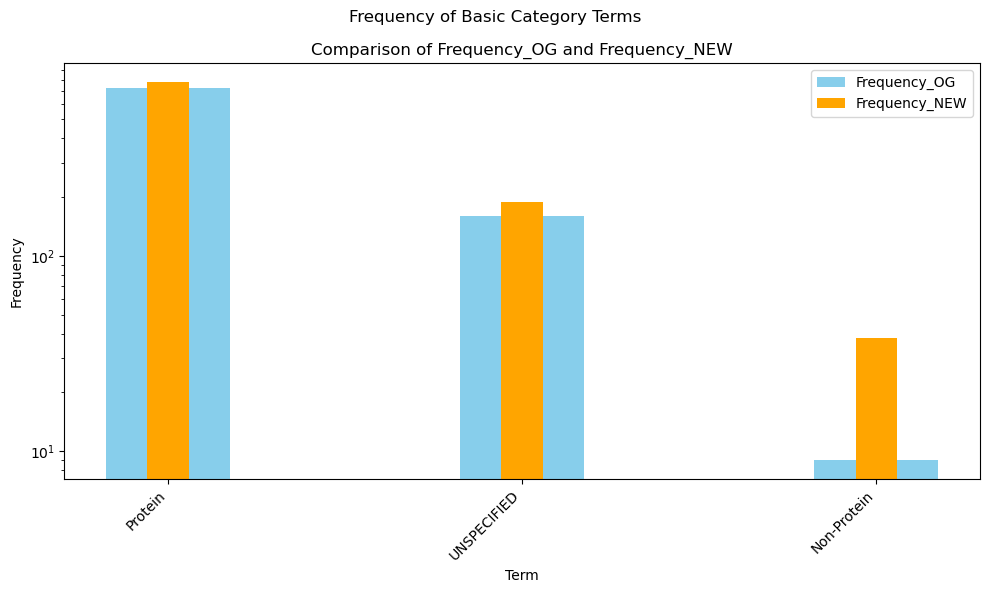

In [12]:
plot_comparison_bar(simple_term_merged_df, "Frequency_OG", "Frequency_NEW", "Basic Category")

## Protein Families (from Pharos)
Visualize the frequency of protein families for all protein targets which have a UniProt ID. 

In [13]:
def get_protein_family(uniprot_id: str):
    # get the protein family from pharos using GraphQL api
    api_url = "https://pharos-api.ncats.io/graphql"
    query_str = f"""
        query targetDetails {{
        target(q: {{uniprot: "{uniprot_id}"}}) {{
            fam
        }}
        }}
        """
    response = requests.post(api_url, json={'query': query_str})
    family = None
    if response.status_code == 200:
        data = response.json()
        if data['data']['target'] is not None:
            family = data['data']['target']['fam']
    else:
        print(f"Failed to fetch data for uniprot_id: {uniprot_id}. Error: {response.status_code}")
    return family

In [14]:
def create_protein_family_json_file(target_data: dict, json_file: str):
    if os.path.exists(json_file):
        return
    uniprot2fam = {}
    for aid, target_list in tqdm(target_data.items(), "Getting protein target families..."):
        if target_list is not None: # some AIDs have no target information
            for target in target_list:
                uniprot_id =  target.get('uniprot_id', None)
                if uniprot_id is not None:
                    uniprot2fam[uniprot_id] = get_protein_family(uniprot_id)
    with open(json_file, "w") as f:
        json.dump(uniprot2fam, f, indent=4)

In [15]:
def get_protein_families(json_file: str):
    protein_families_dict = load_json_file(json_file)
    # map None to "NULL" value for plotting purposes
    # here None means the target is a protein w/ a uniprot id, but the uniprot id is not in pharos
    protein_families = list(map(lambda x: "NULL" if x is None else x, protein_families_dict.values()))
    return protein_families

In [16]:
# will want to cache JSON file to avoid re-running requests
data_dir_1 = os.path.dirname(TARGETS_JSON_FILE_1)
PHAROS_FAMILIES_JSON_1 = os.path.join(data_dir_1, "uniprot2family_tested.json")
data_dir_2 = os.path.dirname(TARGETS_JSON_FILE_2)
PHAROS_FAMILIES_JSON_2 = os.path.join(data_dir_2, "uniprot2family_hts_20000.json")

In [17]:
create_protein_family_json_file(target_data_1, PHAROS_FAMILIES_JSON_1)
create_protein_family_json_file(target_data_2, PHAROS_FAMILIES_JSON_2)

In [18]:
protein_families_1 = get_protein_families(PHAROS_FAMILIES_JSON_1)
protein_families_2 = get_protein_families(PHAROS_FAMILIES_JSON_2)

In [19]:
family_freq_df_1 = get_frequency_df(protein_families_1)
family_freq_df_2 = get_frequency_df(protein_families_2)
family_freq_merged = get_merged_freq_df(family_freq_df_1, family_freq_df_2)
family_freq_merged

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,NULL,175,183,8
1,Enzyme,82,92,10
2,GPCR,43,45,2
3,Kinase,25,30,5
4,NR,12,12,0
5,TF,12,14,2
6,Epigenetic,10,12,2
7,IC,10,10,0
8,Transporter,5,5,0
9,TF; Epigenetic,2,2,0


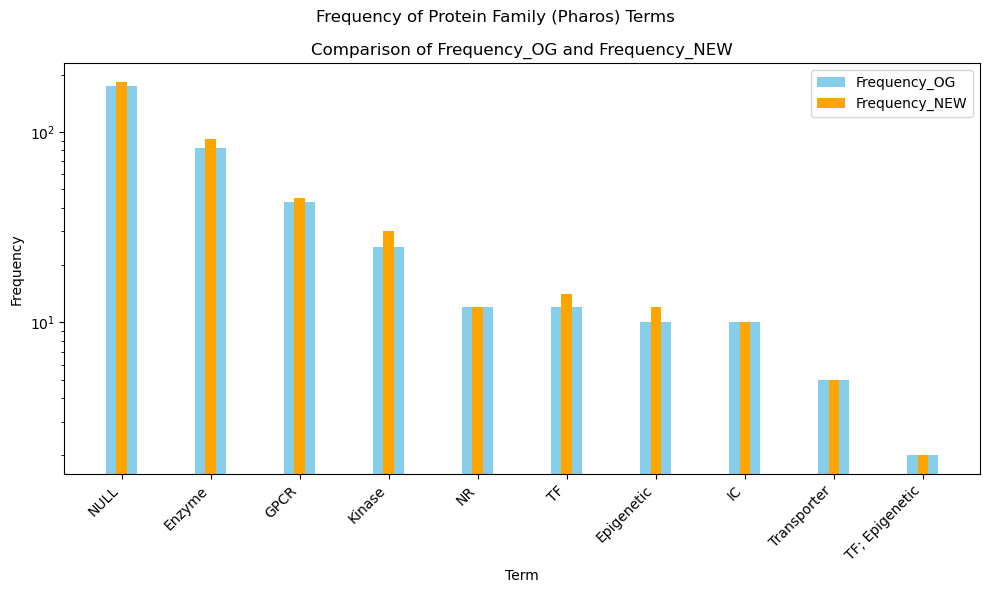

In [20]:
plot_comparison_bar(family_freq_merged, "Frequency_OG", "Frequency_NEW", "Protein Family (Pharos)")

## Target Organisms

In [21]:
def get_taxname(target: dict):
    if "organism" in target:
        if "org" in target["organism"]:
            return target["organism"]["org"].get("taxname", "NULL")
    return "NULL"

def get_taxnames(target_data: dict):
    organism_taxnames = []
    for aid, target_list in target_data.items():
            if target_list is not None: # some AIDs have no target information
                for target in target_list:
                    taxname = get_taxname(target)
                    organism_taxnames.append(taxname)
    return organism_taxnames

In [22]:
organism_taxnames_1 = get_taxnames(target_data_1)
organism_taxnames_2 = get_taxnames(target_data_2)
taxname_freq_df_1 = get_frequency_df(organism_taxnames_1)
taxname_freq_df_2 = get_frequency_df(organism_taxnames_2)
taxname_merged = get_merged_freq_df(taxname_freq_df_1, taxname_freq_df_2)

In [23]:
# view organisms which appear more than once in new data
taxname_merged[taxname_merged['Frequency_NEW'] > 1]

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
0,Homo sapiens,532,548,16
1,Mus musculus,31,31,0
2,NULL,23,89,66
3,Rattus norvegicus,13,13,0
4,Saccharomyces cerevisiae,7,7,0
5,Mycobacterium tuberculosis H37Rv,7,7,0
6,Escherichia coli,6,6,0
7,Human immunodeficiency virus 1,6,6,0
8,Escherichia coli str. K-12 substr. MG1655,6,6,0
9,Bos taurus,6,6,0


In [24]:
# organisms which appear only once in new data
taxname_merged[taxname_merged['Frequency_NEW'] <= 1]

,Term,Frequency_OG,Frequency_NEW,Frequency_Diff
34,Infectious bronchitis virus,1,1,0
35,Clostridium botulinum A str. ATCC 3502,1,1,0
36,Yersinia pestis CO92,1,1,0
37,Lake Victoria marburgvirus,1,1,0
38,Photuris pennsylvanica,1,1,0
39,Clostridium botulinum Bf,1,1,0
40,Dengue virus 2 16681-PDK53,1,1,0
41,Influenza A virus (A/California/07/2009(H1N1)),1,1,0
42,Staphylococcus aureus subsp. aureus N315,1,1,0
43,Mycobacterium tuberculosis UT205,1,1,0


In [25]:
# for the sake of plotting, group together organisms which occur <= 5 times
taxname_freq_df_1 = get_high_frequency_df(taxname_freq_df_1, 5)
taxname_freq_df_2 = get_high_frequency_df(taxname_freq_df_2, 5)
taxname_high_freq = get_merged_freq_df(taxname_freq_df_1, taxname_freq_df_2)

/tmp/ipykernel_154406/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]
/tmp/ipykernel_154406/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


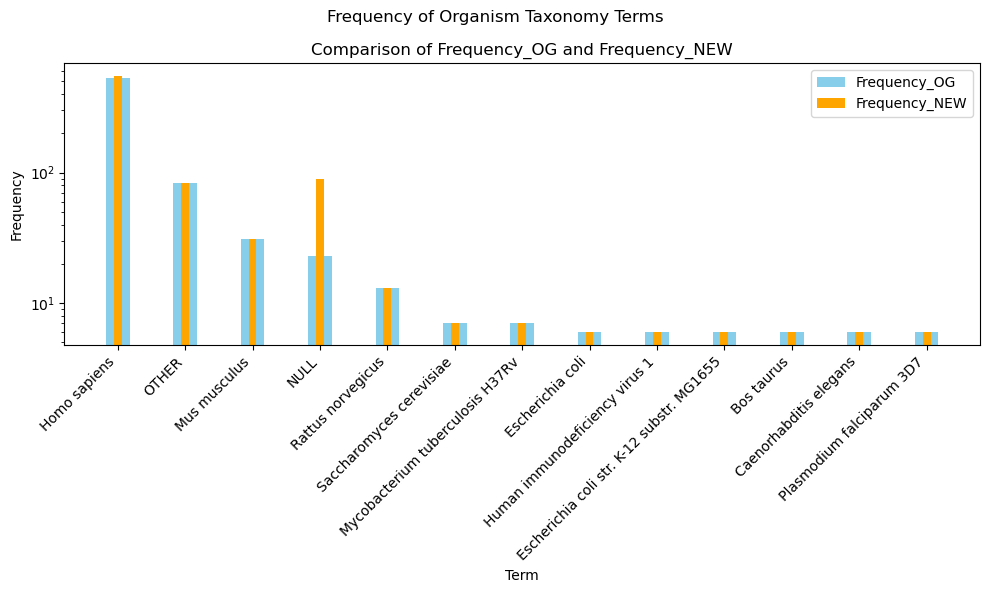

In [26]:
plot_comparison_bar(taxname_high_freq, "Frequency_OG", "Frequency_NEW", "Organism Taxonomy")